# Week 5 - Reliability

intro stuff...

In [4]:
#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data).

In [5]:
x = np.loadtxt("data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [6]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ..., 
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [7]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [8]:
anno.missing_values

[-1]

# Annotation Statistics

Compute Cohen's kappa statistics, which measures the extent of agreement between two annotators. Here, Cohen's kappa statistics for the first two annotators are computed.

In [9]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

Get the pairwise measure matrix.

In [10]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.43917037  0.47677621         nan         nan         nan
   0.45819119  0.43381462]
 [ 0.43917037  1.          0.38432922  0.41344423         nan         nan
          nan  0.33643611]
 [ 0.47677621  0.38432922  1.          0.39583333  0.51704894         nan
          nan         nan]
 [        nan  0.41344423  0.39583333  1.          0.34597068  0.4446844
          nan         nan]
 [        nan         nan  0.51704894  0.34597068  1.          0.37938644
   0.43039733         nan]
 [        nan         nan         nan  0.4446844   0.37938644  1.
   0.38341929  0.31214748]
 [ 0.45819119         nan         nan         nan  0.43039733  0.38341929
   1.          0.394806  ]
 [ 0.43381462  0.33643611         nan         nan         nan  0.31214748
   0.394806    1.        ]]


A heatmap visualization:

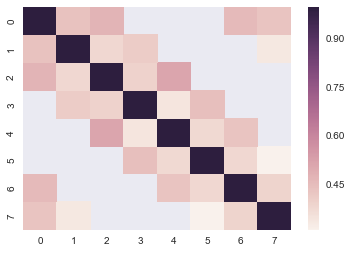

In [13]:
ax = seaborn.heatmap(m)
plt.show()

# Models

Now we use Rzhetsky et al (2009)'s models to make inference about true label classes. Pyanno provides four available models: ModelA, ModelB, ModelBt, and ModelBtLoopDesign. They should give similar results. To estimate the parameters for any models, we first need to create a new model. 

In [14]:
# create a new instance of model A, with 4 label classes
model = ModelA.create_initial_state(4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.68611713  0.65615533  0.62166666  0.85972158  0.80022894  0.74122738
  0.91483007  0.74809751]
-3217.2397715


Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. The estimates should not differ a lot. Note that the parameters here are the accuracy of each annotator.

In [15]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79543135  0.73330785  0.76949679  0.71017779  0.72276622  0.71932738
  0.75785625  0.71250168]
-2817.51934092


In [16]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79471078  0.73220091  0.76872921  0.7089503   0.72169019  0.71812133
  0.75682088  0.71119356]
-2817.51365396


After we have model parameters estimated, we can make inference about the true label classes. We can calculate the posterior distribution over the true label classes.

In [17]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[ 0.02765687  0.37909309  0.26774666  0.32550338]
 [ 0.99573298  0.00142234  0.00142234  0.00142234]
 [ 0.00930068  0.10339981  0.87799883  0.00930068]
 ..., 
 [ 0.00955677  0.07871263  0.90217384  0.00955677]
 [ 0.00955677  0.00955677  0.90217384  0.07871263]
 [ 0.07871263  0.90217384  0.00955677  0.00955677]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [ ]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

sample_posterior_over_accuracy() allows drawing samples from the posterior of the accuracy parameters. We can use such samples to draw credible intervals.

In [ ]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
print(samples.mean(axis=0))
print(samples.std(axis=0))

Let's try everything again with ModelBt

In [19]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.82252709  0.74118633  0.9064654   0.72998346  0.60284001  0.80251441
  0.71668827  0.66550549]
-2882.57452909


In [20]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79131911  0.74065405  0.76222051  0.72521471  0.71649628  0.7186344
  0.77322093  0.71668542]
-2811.94631482


In [21]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[ 0.01110807  0.28937715  0.36489129  0.3346235 ]
 [ 0.99022065  0.00241932  0.00405065  0.00330939]
 [ 0.00250095  0.05507671  0.93458812  0.00783421]
 ..., 
 [ 0.00253034  0.04397386  0.94556953  0.00792627]
 [ 0.00249529  0.00571421  0.93247178  0.05931872]
 [ 0.03191985  0.93877778  0.01612678  0.0131756 ]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

In [ ]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [ ]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

# Visualization

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipyton notebook. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [ ]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

In [ ]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Examples from the GSS Study.

Getting the data for each GSS question.

In [23]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [24]:
dev.shape

(21461, 6)

In [25]:
anno_dv.labels

[0, 1]

In [26]:
anno_dv.missing_values

[-1]

In [27]:
anno_dv.annotations.shape

(21461, 6)

Measure agreement between coders.

In [28]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[ 1.          0.62426874  0.46682841  0.44599604  0.16569888  0.36657805]
 [ 0.62426874  1.          0.53480937  0.52673854  0.3306905   0.59513211]
 [ 0.46682841  0.53480937  1.          0.50580068  0.42393752  0.49833997]
 [ 0.44599604  0.52673854  0.50580068  1.          0.46517493  0.47023754]
 [ 0.16569888  0.3306905   0.42393752  0.46517493  1.          0.66190749]
 [ 0.36657805  0.59513211  0.49833997  0.47023754  0.66190749  1.        ]]


Visualization

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

Let's compute the statistics on each of the dataset and also try computing the pearsons r. 

In [30]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

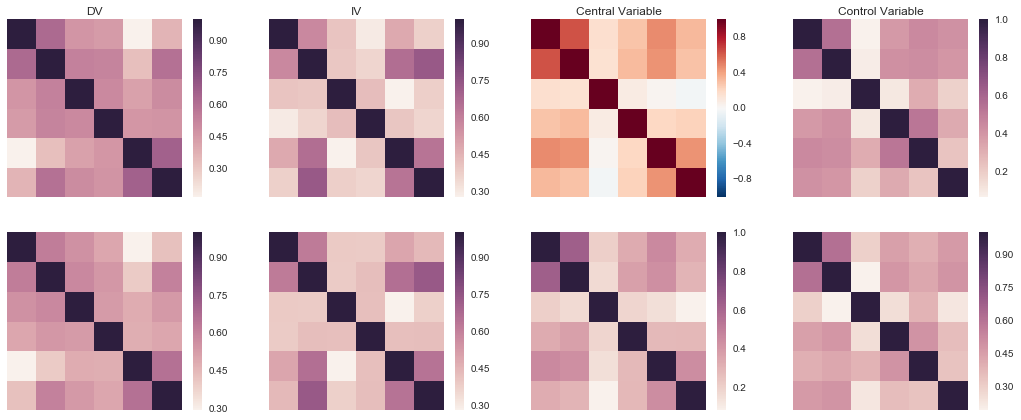

In [36]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Test the comparison of students

In [37]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [38]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.472142584454
0.514240727822
0.45296278237
0.475965268669
0.270823768698
0.315140498284
0.328334778759
0.39458527792


Bring in merge data: author_dependent, mode_dependent, author_independent, mode_independent, author_central, mode_central, author_control, mode_control, author_don't_know, mode_don't_know

In [39]:
mergedata = np.loadtxt(fname="data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [40]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [ ]:
print("Dependent variable")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Now for the assessment of the relative values of authors, then student coders.

In [80]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.476391231029
0.358347386172

Independent
0.237774030354
0.313659359191

Central
0.35328836425
0.751264755481

Control
0.0817875210793
0.0944350758853


Hacking the Model A (by adding two blank columns)

In [81]:
dev.shape

(21461, 6)

In [82]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [83]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([ 0.76444569,  0.62857133,  0.68009531,  0.7293642 ,  0.68938183,
        0.85320052,  0.60799183,  0.6880875 ])

In [47]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[ 0.06282873  0.93717127]
-44953.897415


In [48]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[ 0.69455487  0.30544513]
-25462.473635


In [84]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

[[ 0.01110807  0.28937715  0.36489129  0.3346235 ]
 [ 0.99022065  0.00241932  0.00405065  0.00330939]
 [ 0.00250095  0.05507671  0.93458812  0.00783421]
 ..., 
 [ 0.00253034  0.04397386  0.94556953  0.00792627]
 [ 0.00249529  0.00571421  0.93247178  0.05931872]
 [ 0.03191985  0.93877778  0.01612678  0.0131756 ]]


In [50]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [87]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


Mean
[[[ 0.97942413  0.02057587]
  [ 0.51494564  0.48505436]]

 [[ 0.96902939  0.03097061]
  [ 0.26046685  0.73953315]]

 [[ 0.98276978  0.01723022]
  [ 0.34698508  0.65301492]]

 [[ 0.93501127  0.06498873]
  [ 0.24025595  0.75974405]]

 [[ 0.69251804  0.30748196]
  [ 0.0462454   0.9537546 ]]

 [[ 0.86385975  0.13614025]
  [ 0.06945103  0.93054897]]]

STD
[[[ 0.00219337  0.00219337]
  [ 0.01180393  0.01180393]]

 [[ 0.00309346  0.00309346]
  [ 0.01370429  0.01370429]]

 [[ 0.00291537  0.00291537]
  [ 0.01392741  0.01392741]]

 [[ 0.00530864  0.00530864]
  [ 0.01101134  0.01101134]]

 [[ 0.00636331  0.00636331]
  [ 0.00613368  0.00613368]]

 [[ 0.00636342  0.00636342]
  [ 0.00785284  0.00785284]]]


B estimates for other variables

In [52]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-103.075182648
[  9.20933481e-20   1.00000000e+00]
-48.9756711394
(48, 6)
(48, 2)
[[[ 0.8127639   0.1872361 ]
  [ 0.13116682  0.86883318]]

 [[ 0.79752687  0.20247313]
  [ 0.09257663  0.90742337]]

 [[ 0.81324496  0.18675504]
  [ 0.50493178  0.49506822]]

 [[ 0.7952655   0.2047345 ]
  [ 0.07285611  0.92714389]]

 [[ 0.78629782  0.21370218]
  [ 0.34998801  0.65001199]]

 [[ 0.80143179  0.19856821]
  [ 0.12372194  0.87627806]]]


In [73]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-37195.1545325
[ 0.61093546  0.38906454]
-28620.6652325
(21461, 6)
(21461, 2)
[[[ 0.97078881  0.02921119]
  [ 0.34774373  0.65225627]]

 [[ 0.93738475  0.06261525]
  [ 0.05439985  0.94560015]]

 [[ 0.65807089  0.34192911]
  [ 0.21079757  0.78920243]]

 [[ 0.53677762  0.46322238]
  [ 0.03039061  0.96960939]]

 [[ 0.87654891  0.12345109]
  [ 0.09785665  0.90214335]]

 [[ 0.89060245  0.10939755]
  [ 0.09038631  0.90961369]]]
-49191.9964967
[ 0.23988844  0.76011156]
-25034.9185558
(21461, 6)
(21461, 2)
[[[ 0.88688692  0.11311308]
  [ 0.06947406  0.93052594]]

 [[ 0.783935    0.216065  ]
  [ 0.05664245  0.94335755]]

 [[ 0.99195932  0.00804068]
  [ 0.84115255  0.15884745]]

 [[ 0.95121485  0.04878515]
  [ 0.45554475  0.54445525]]

 [[ 0.67572483  0.32427517]
  [ 0.05629504  0.94370496]]

 [[ 0.5896543   0.4103457 ]
  [ 0.09456176  0.90543824]]]
-31966.457264
[ 0.83068326  0.16931674]
-19415.7020352
(21461, 6)
(21461, 2)
[[[ 0.97050486  0.02949514]
  [ 0.34518704  0.65481296]]

 [[ 0.9359431

Now for the Bt models

Bt estimates for other variables, incompatiable models

Package up into something testable against author data

In [78]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [79]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [63]:
predicted_annotations.shape

(21461, 8)

In [64]:
np.savetxt("B_outputs.txt", predicted_annotations, delimiter='\t')